In [1]:
%load_ext autoreload
%autoreload 2

import cstrees.cstree as ct
import numpy as np
import networkx as nx
import logging, sys
import cstrees.scoring as sc

logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)

# CStree from Figure 1 in (Duarte & Solus, 2022)


[[1 0 0 0]
 [0 0 1 1]
 [1 0 1 0]
 [0 1 1 0]
 [1 1 0 1]]
level 0
possible context values at row 0: []
is in the stage None
possible context values at row 1: []
is in the stage None
possible context values at row 2: []
is in the stage None
possible context values at row 3: []
is in the stage None
possible context values at row 4: []
is in the stage None
[]: {1: 3, 0: 2}
level 1
possible context values at row 0: [1]
is in the stage None
possible context values at row 1: [0]
is in the stage None
possible context values at row 2: [1]
is in the stage None
possible context values at row 3: [0]
is in the stage None
possible context values at row 4: [1]
is in the stage None
[1]: {0: 2, 1: 1}
[0]: {0: 1, 1: 1}
level 2
possible context values at row 0: [1 0]
is in the stage [{0, 1}, 0]
possible context values at row 1: [0 0]
is in the stage [{0, 1}, 0]
possible context values at row 2: [1 0]
is in the stage [{0, 1}, 0]
possible context values at row 3: [0 1]
is in the stage None
possible context 

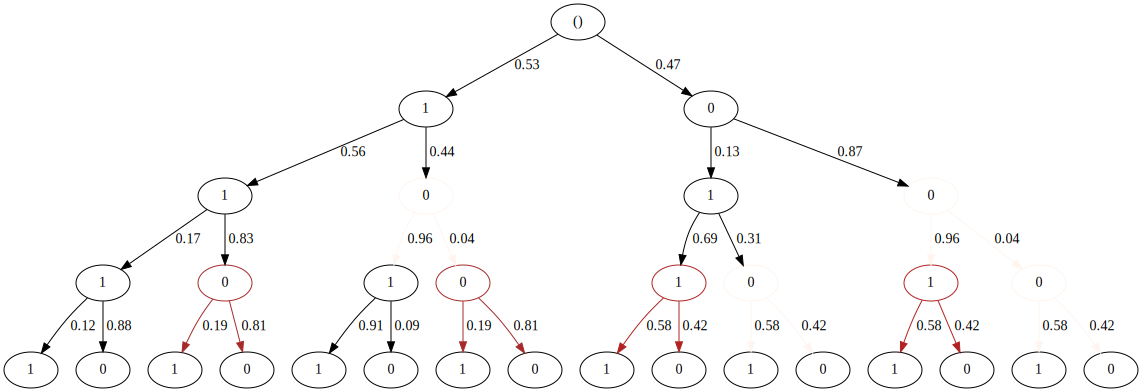

In [60]:
np.random.seed(2)
p=4
cards = [2] * p
co = ct.CausalOrder(range(p))
tree = ct.CStree(co)


#stage = ct.sample_random_stage(cards,2)
#stage.set_random_params(cards)

tree.set_cardinalities(cards)

# These do not have to be in a dict like this as the levels are
# determined from the length of the tuples.

tree.set_stages({
    0: [],
    1: [ct.Stage([{0, 1}, 0])],    # Green
    2: [ct.Stage([0, {0, 1}, 0]),  # Blue
        ct.Stage([0, {0, 1}, 1]),  # Orange
        ct.Stage([1, {0, 1}, 0])]  # Red
})


tree.set_random_stage_parameters()


a = tree.plot()
a.draw("testplot.png")
x = tree.sample(5)

#x = tree.sample(5)
print(x)

s = sc.score(tree, x, alpha_tot=1.0, method="K2")
print(s)
#rels = tree.csi_relations()

#print("Initial rels")
#print(rels)
adjmats = tree.to_minimal_context_graphs()

for key, graph in adjmats.items():
    agraph = nx.nx_agraph.to_agraph(graph)
    agraph.layout("dot")
    agraph.draw(str(key) + "_csi.png", args='-Glabel="'+str(key)+'"   ')
a

In [7]:
tree.to_df()

,0,1,2,3
0,2,2,2,2
0,*,0,-,-
0,0,*,0,-
0,0,*,1,-
0,1,*,0,-


In [68]:
order

[0, 1, 2, 3]

full_stage_space_size: 2
level: 0, mc: 1, minimal_stage_size: 1
full_stage_space_size: 4
level: 1, mc: 2, minimal_stage_size: 1
full_stage_space_size: 8
level: 2, mc: 2, minimal_stage_size: 2


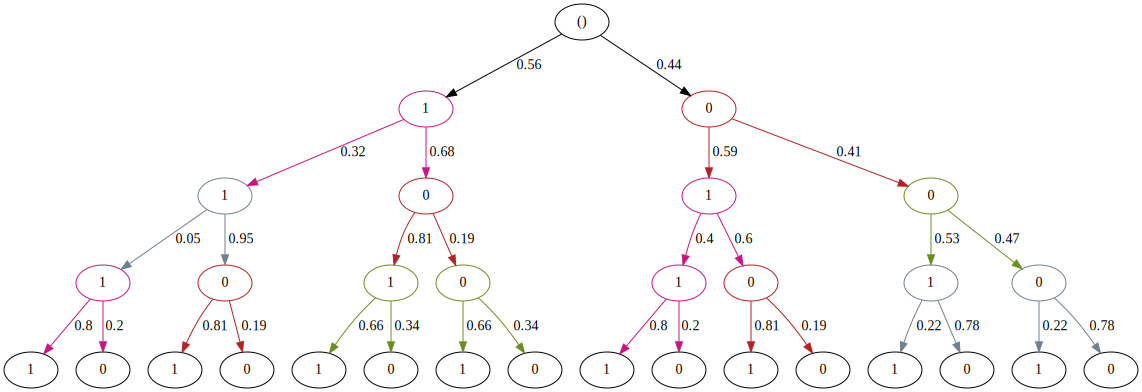

In [94]:

t = ct.sample_cstree(cards, max_cvars=2, prob_cvar=1, prop_nonsingleton=1)
t.set_random_stage_parameters()
a = t.plot()
x = t.sample(5)

a

In [90]:

level = 2
score = sc.score_order(order, cards, x, max_cvars=1, alpha_tot=1.0, method="BDeu")
print(score)
stagings = ct.all_stagings(order, cards, level, max_cvars=1)
print("Stagings")
nst = ct.n_stagings(order, cards, level, max_cvars=1)
print(nst)
print("Stagings")
for ss in stagings:
    for s in ss:
        print(s)


max_staging, max_score = ct.max_score_staging(order, cards, x, level, max_cvars=1, alpha_tot=1.0, method="BDeu")
print(max_staging)
print(max_score)    

level 0
stlist: [<cstrees.cstree.Stage object at 0x7fc974d40af0>, <cstrees.cstree.Stage object at 0x7fc974b872b0>]
possible context values at row 1: []
[] is in the stage None
possible context values at row 2: []
[] is in the stage None
possible context values at row 3: []
[] is in the stage None
possible context values at row 4: []
[] is in the stage None
[]: {0: 1, 1: 4}
stlist: [<cstrees.cstree.Stage object at 0x7fc974d40460>]
possible context values at row 1: []
[] is in the stage None
possible context values at row 2: []
[] is in the stage None
possible context values at row 3: []
[] is in the stage None
possible context values at row 4: []
[] is in the stage None
[]: {0: 1, 1: 4}
level 1
stlist: [<cstrees.cstree.Stage object at 0x7fc974d40d60>, <cstrees.cstree.Stage object at 0x7fc974b87280>]
stages at level 0: [<cstrees.cstree.Stage object at 0x7fc974d40460>]
stages at level 0: [<cstrees.cstree.Stage object at 0x7fc974d40460>]
possible context values at row 1: [1]
[1] is in the 

In [30]:
np.inf >4

True